# DoubleML meets FLAML - How to tune learners automatically within `DoubleML`

Recent advances in automated machine learning make it easier to tune hyperparameters of ML estimators automatically. These optimized learners can be used for the estimation part within DoubleML. In this notebook we are going to explore how to tune learners with AutoML for the DoubleML framework.

This notebook will use [FLAML](https://github.com/microsoft/FLAML), but there are also many other AutoML frameworks. Particularly useful for DoubleML are packages that provide some way to export the model in `sklearn`-style.

Examples are: [TPOT](https://epistasislab.github.io/tpot/), [autosklearn](https://automl.github.io/auto-sklearn/master/), [H20](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html) or [Gama](https://github.com/amore-labs/gama).

## Data Generation

We create synthetic data using the [make_plr_CCDDHNR2018()](https://docs.doubleml.org/stable/api/generated/doubleml.datasets.make_plr_CCDDHNR2018.html) process, with $1000$ observations of $50$ covariates as well as $1$ treatment variable and an outcome. We calibrate the process such that hyperparameter tuning becomes more important.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from doubleml.plm.datasets import make_plr_CCDDHNR2018
import doubleml as dml
from flaml import AutoML
from xgboost import XGBRegressor

# Generate synthetic data
data = make_plr_CCDDHNR2018(alpha=0.5, n_obs=1000, dim_x=50, return_type="DataFrame", a0=0, a1=1, s1=0.25, s2=0.25)
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X43,X44,X45,X46,X47,X48,X49,X50,y,d
0,-0.262083,-1.119409,-0.509651,0.041262,-0.669130,-0.901998,-0.721118,0.137230,0.394757,0.785979,...,1.493792,0.671420,0.162752,0.390155,-0.654964,0.218223,0.730629,0.196835,1.298150,0.156328
1,-1.025407,-0.557741,0.299755,0.581880,0.833563,1.164943,0.790142,-0.272505,1.518978,1.865442,...,-0.158682,0.261686,-1.087566,-1.289983,-2.077090,-2.248487,-1.363576,-0.169858,-2.225764,-1.225917
2,1.685143,0.375995,0.088836,0.731928,1.267164,0.227086,0.665974,2.038831,2.151447,1.858635,...,-0.250529,0.311740,1.307444,0.364276,-0.903731,0.250838,-0.110742,-1.305142,1.482508,2.249306
3,0.424573,0.416737,-0.277987,-0.054064,-0.924540,-0.461396,-0.520096,0.088082,-0.501203,0.042060,...,1.401009,0.546260,-0.010045,1.069144,0.222306,0.033779,0.788267,-0.028146,-0.524817,-0.033661
4,-0.771529,-0.110557,0.384208,0.444805,-0.396272,0.713582,-0.264426,-1.066478,0.622502,1.088792,...,-0.067436,-0.114026,1.384189,1.627319,0.430345,-0.331215,-0.748284,0.878122,-0.695582,-0.186864


## Tuning on the full Sample

In this section, we manually tune two [XGBoost](https://xgboost.readthedocs.io/en/stable/) models using FLAML for a [Partially Linear Regression Model](https://docs.doubleml.org/stable/guide/models.html#partially-linear-regression-model-plr). In the PLR (using the default score) we have to estimate a nuisance $\eta$ consisting of

$$\eta := \{m_0(x), \ell_0(x)\} = \{\mathbb{E}[D|X], \mathbb{E}[Y|X]\}.$$

We initialize two `FLAML` AutoML objects and fit them accordingly. Once the tuning has been completed, we pass the learners to `DoubleML`.

#### Step 1: Initialize and Train the AutoML Models:

*Note: This cell will optimize the nuisance models for 8 minutes in total.*

In [18]:
# Initialize AutoML for outcome model (ml_l): Predict Y based on X
automl_l = AutoML()
settings_l = {
    "time_budget": 240,
    "metric": 'rmse',
    "estimator_list": ['xgboost'],
    "task": 'regression',
}
automl_l.fit(X_train=data.drop(columns=["y", "d"]).values, y_train=data["y"].values, verbose=2, **settings_l)

# Initialize AutoML for treatment model (ml_m): Predict D based on X
automl_m = AutoML()
settings_m = {
    "time_budget": 240,
    "metric": 'rmse',
    "estimator_list": ['xgboost'],
    "task": 'regression',
}
automl_m.fit(X_train=data.drop(columns=["y", "d"]).values, y_train=data["d"].values, verbose=2, **settings_m)


#### Step 2: Evaluate the Tuned Models 

`FLAML` reports the best loss during training as `best_loss` attribute. For more details, we refer to the [FLAML documentation](https://microsoft.github.io/FLAML/docs/Getting-Started).

In [19]:
rmse_oos_ml_m = automl_m.best_loss
rmse_oos_ml_l = automl_l.best_loss
print("Best RMSE during tuning (ml_m):",rmse_oos_ml_m)
print("Best RMSE during tuning (ml_l):",rmse_oos_ml_l)

Best RMSE during tuning (ml_m): 1.002037900301454
Best RMSE during tuning (ml_l): 1.0929369228758206


#### Step 3: Create and Fit DoubleML Model

We create a `DoubleMLData` object with the dataset, specifying $y$ as the outcome variable and $d$ as the treatment variable. We then initialize a `DoubleMLPLR` model using the tuned `FLAML` estimators for both the treatment and outcome components. `DoubleML` will use copies with identical configurations on each fold.

In [20]:
obj_dml_data = dml.DoubleMLData(data, "y", "d")

obj_dml_plr_fullsample = dml.DoubleMLPLR(obj_dml_data, ml_m=automl_m.model.estimator,
                                           ml_l=automl_l.model.estimator)

print(obj_dml_plr_fullsample.fit().summary)

       coef   std err          t         P>|t|     2.5 %    97.5 %
d  0.490689  0.031323  15.665602  2.599586e-55  0.429298  0.552081


`DoubleML`'s built-in learner evaluation reports the out-of-sample error during cross-fitting. We can compare this measure to the best loss during training from above.

In [21]:
rmse_dml_ml_l_fullsample = obj_dml_plr_fullsample.evaluate_learners()['ml_l'][0][0]
rmse_dml_ml_m_fullsample = obj_dml_plr_fullsample.evaluate_learners()['ml_m'][0][0]

print("RMSE evaluated by DoubleML (ml_m):", rmse_dml_ml_m_fullsample)
print("RMSE evaluated by DoubleML (ml_l):", rmse_dml_ml_l_fullsample)


RMSE evaluated by DoubleML (ml_m): 1.0124105481660435
RMSE evaluated by DoubleML (ml_l): 1.103179163001313


The best RMSE during automated tuning and the out-of-sample error in nuisance prediction are similar, which hints that there is no overfitting. We don't expect large amounts of overfitting, since FLAML uses cross-validation internally and reports the best loss on a hold-out sample.

## Tuning on the Folds

Instead of externally tuning the `FLAML` learners, it is also possible to tune the AutoML learners internally. We have to define custom classes for integrating `FLAML` to `DoubleML`. The tuning will be automatically be started when calling `DoubleML`'s `fit()` method. Training will occure $K$ times, so each fold will have an individualized optimal set of hyperparameters.

#### Step 1: Custom API for FLAML Models within `DoubleML`

The following API is designed to facilitate automated machine learning model tuning for both regression and classification tasks. In this example however, we will only need the Regressor API as the treatment is continous.

In [22]:
from sklearn.utils.multiclass import unique_labels

class FlamlRegressorDoubleML:
    _estimator_type = 'regressor'

    def __init__(self, time, estimator_list, metric, *args, **kwargs):
        self.auto_ml = AutoML(*args, **kwargs)
        self.time = time
        self.estimator_list = estimator_list
        self.metric = metric

    def set_params(self, **params):
        self.auto_ml.set_params(**params)
        return self

    def get_params(self, deep=True):
        dict = self.auto_ml.get_params(deep)
        dict["time"] = self.time
        dict["estimator_list"] = self.estimator_list
        dict["metric"] = self.metric
        return dict

    def fit(self, X, y):
        self.auto_ml.fit(X, y, task="regression", time_budget=self.time, estimator_list=self.estimator_list, metric=self.metric, verbose=False)
        self.tuned_model = self.auto_ml.model.estimator
        return self

    def predict(self, x):
        preds = self.tuned_model.predict(x)
        return preds
        
class FlamlClassifierDoubleML:
    _estimator_type = 'classifier'

    def __init__(self, time, estimator_list, metric, *args, **kwargs):
        self.auto_ml = AutoML(*args, **kwargs)
        self.time = time
        self.estimator_list = estimator_list
        self.metric = metric

    def set_params(self, **params):
        self.auto_ml.set_params(**params)
        return self

    def get_params(self, deep=True):
        dict = self.auto_ml.get_params(deep)
        dict["time"] = self.time
        dict["estimator_list"] = self.estimator_list
        dict["metric"] = self.metric
        return dict

    def fit(self, X, y):
        self.classes_ = unique_labels(y)
        self.auto_ml.fit(X, y, task="classification", time_budget=self.time, estimator_list=self.estimator_list, metric=self.metric, verbose=False)
        self.tuned_model = self.auto_ml.model.estimator
        return self

    def predict_proba(self, x):
        preds = self.tuned_model.predict_proba(x)
        return preds

#### Step 2: Using the API when calling `DoubleML`'s `.fit()` Method

We initialize a `FlamlRegressorDoubleML` and hand it without fitting into the DoubleML object. When calling `.fit()` on the DoubleML object, copies of the API object will be created on the folds and a seperate set of hyperparameters is created. Since we fit $K$ times, we reduce the computation time accordingly to ensure comparibility to the full sample case.

In [23]:
# Define the FlamlRegressorDoubleML
ml_l = FlamlRegressorDoubleML(time=24, estimator_list=['xgboost'], metric='rmse')
ml_m = FlamlRegressorDoubleML(time=24, estimator_list=['xgboost'], metric='rmse')

# Create DoubleMLPLR object using the new regressors
dml_plr_obj_onfolds = dml.DoubleMLPLR(obj_dml_data, ml_m, ml_l)

# Fit the DoubleMLPLR model
print(dml_plr_obj_onfolds.fit(store_models=True).summary)

       coef   std err          t         P>|t|     2.5 %    97.5 %
d  0.488455  0.031491  15.510971  2.924232e-54  0.426734  0.550176


In [24]:
rmse_oos_onfolds_ml_l = np.mean([dml_plr_obj_onfolds.models["ml_l"]["d"][0][i].auto_ml.best_loss for i in range(5)])
rmse_oos_onfolds_ml_m = np.mean([dml_plr_obj_onfolds.models["ml_m"]["d"][0][i].auto_ml.best_loss for i in range(5)])
print("Best RMSE during tuning (ml_m):",rmse_oos_onfolds_ml_m)
print("Best RMSE during tuning (ml_l):",rmse_oos_onfolds_ml_l)

rmse_dml_ml_l_onfolds = dml_plr_obj_onfolds.evaluate_learners()['ml_l'][0][0]
rmse_dml_ml_m_onfolds = dml_plr_obj_onfolds.evaluate_learners()['ml_m'][0][0]

print("RMSE evaluated by DoubleML (ml_m):", rmse_dml_ml_m_onfolds)
print("RMSE evaluated by DoubleML (ml_l):", rmse_dml_ml_l_onfolds)

Best RMSE during tuning (ml_m): 1.0060715124549546
Best RMSE during tuning (ml_l): 1.1030891095588866
RMSE evaluated by DoubleML (ml_m): 1.0187512020118494
RMSE evaluated by DoubleML (ml_l): 1.1016338581630878


Similar to the above case, we see no hints for overfitting.

### Comparison to AutoML with less Computation time and Untuned XGBoost Learners

#### AutoML with less Computation time

As a baseline, we can compare the learners above that have been tuned using two minutes of training time each with ones that only use ten seconds.

Note: These tuning times are examples. For this setting, we found 10s to be insuffienct and 120s to be sufficient. In general, necessary tuning time can depend on data complexity, data set size, computational power of the machine used, etc.. For more info on how to use ``FLAML`` properly please refer to [the documentation](https://microsoft.github.io/FLAML/docs/Getting-Started/) and [the paper](https://arxiv.org/pdf/1911.04706).

In [25]:
# Initialize AutoML for outcome model similar to above, but use a smaller time budget.
automl_l_lesstime = AutoML()
settings_l = {
    "time_budget": 10,
    "metric": 'rmse',
    "estimator_list": ['xgboost'],
    "task": 'regression',
}
automl_l_lesstime.fit(X_train=data.drop(columns=["y", "d"]).values, y_train=data["y"].values, verbose=2, **settings_l)

# Initialize AutoML for treatment model similar to above, but use a smaller time budget.
automl_m_lesstime = AutoML()
settings_m = {
    "time_budget": 10,
    "metric": 'rmse',
    "estimator_list": ['xgboost'],
    "task": 'regression',
}
automl_m_lesstime.fit(X_train=data.drop(columns=["y", "d"]).values, y_train=data["d"].values, verbose=2, **settings_m)

In [26]:
obj_dml_plr_lesstime = dml.DoubleMLPLR(obj_dml_data, ml_m=automl_m_lesstime.model.estimator,
                                           ml_l=automl_l_lesstime.model.estimator)

print(obj_dml_plr_lesstime.fit().summary)

       coef   std err          t         P>|t|     2.5 %    97.5 %
d  0.461493  0.031075  14.851012  6.852592e-50  0.400587  0.522398


We can check the performance again.

In [27]:
rmse_dml_ml_l_lesstime = obj_dml_plr_lesstime.evaluate_learners()['ml_l'][0][0]
rmse_dml_ml_m_lesstime = obj_dml_plr_lesstime.evaluate_learners()['ml_m'][0][0]


print("Best RMSE during tuning (ml_m):", automl_m_lesstime.best_loss)
print("Best RMSE during tuning (ml_l):", automl_l_lesstime.best_loss)
print("RMSE evaluated by DoubleML (ml_m):", rmse_dml_ml_m_lesstime)
print("RMSE evaluated by DoubleML (ml_l):", rmse_dml_ml_l_lesstime)

Best RMSE during tuning (ml_m): 0.9386744462704798
Best RMSE during tuning (ml_l): 1.0520233166790431
RMSE evaluated by DoubleML (ml_m): 1.0603268864456956
RMSE evaluated by DoubleML (ml_l): 1.111352344760325


We see a more severe difference in oos RMSE between AutoML and DML estimations. This could hint that the learner underfits, i.e. training time was not sufficient.

#### Untuned (default parameter) XGBoost

As another baseline, we set up DoubleML with an XGBoost learner that has not been tuned at all, i.e. using the default set of hyperparameters.

In [28]:
xgb_untuned_m, xgb_untuned_l = XGBRegressor(), XGBRegressor()

In [29]:
# Create DoubleMLPLR object using AutoML models
dml_plr_obj_untuned = dml.DoubleMLPLR(obj_dml_data, xgb_untuned_l, xgb_untuned_m)
print(dml_plr_obj_untuned.fit().summary)

rmse_dml_ml_l_untuned = dml_plr_obj_untuned.evaluate_learners()['ml_l'][0][0]
rmse_dml_ml_m_untuned = dml_plr_obj_untuned.evaluate_learners()['ml_m'][0][0]

       coef   std err          t         P>|t|     2.5 %    97.5 %
d  0.429133  0.031692  13.540578  9.007789e-42  0.367017  0.491249


### Comparison and summary

We combine the summaries from various models: full-sample and on-the-folds tuned AutoML, untuned XGB, and dummy models.

In [30]:
summary = pd.concat([obj_dml_plr_fullsample.summary, dml_plr_obj_onfolds.summary, dml_plr_obj_untuned.summary, obj_dml_plr_lesstime.summary],
                     keys=['Full Sample', 'On the folds', 'Default', 'Less time'])
summary.index.names = ['Model Type', 'Metric']

summary

,,coef,std err,t,P>|t|,2.5 %,97.5 %
Model Type,Metric,,,,,,
Full Sample,d,0.490689,0.031323,15.665602,2.599586e-55,0.429298,0.552081
On the folds,d,0.488455,0.031491,15.510971,2.924232e-54,0.426734,0.550176
Default,d,0.429133,0.031692,13.540578,9.007789e-42,0.367017,0.491249
Less time,d,0.461493,0.031075,14.851012,6.852592e-50,0.400587,0.522398


##### Plot Coefficients and 95% Confidence Intervals

This section generates a plot comparing the coefficients and 95% confidence intervals for each model type.

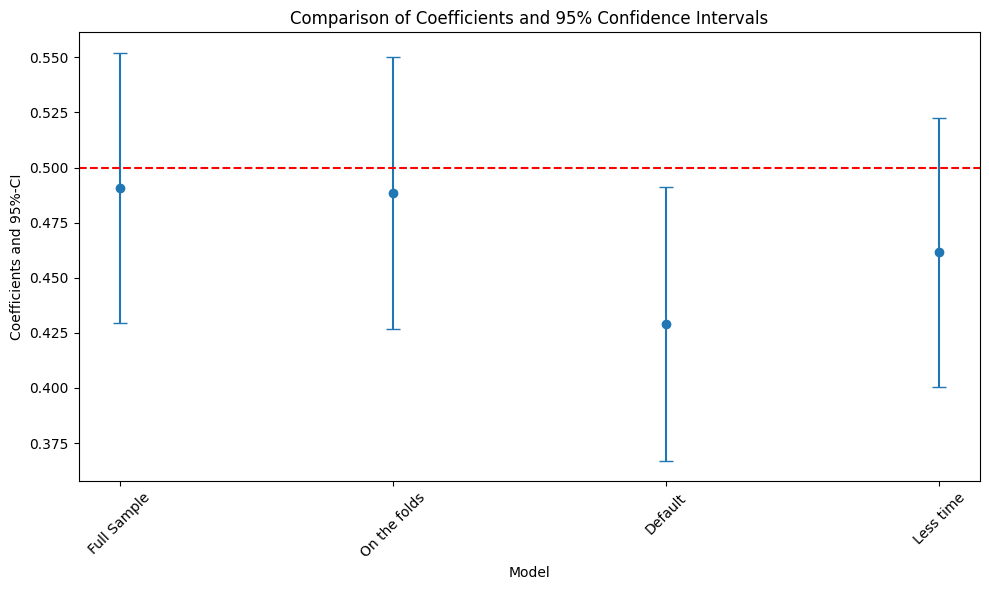

In [31]:
# Extract model labels and coefficient values
model_labels = summary.index.get_level_values('Model Type')
coef_values = summary['coef'].values

# Calculate errors
errors = np.full((2, len(coef_values)), np.nan)
errors[0, :] = summary['coef'] - summary['2.5 %']
errors[1, :] = summary['97.5 %'] - summary['coef']

# Plot Coefficients and 95% Confidence Intervals
plt.figure(figsize=(10, 6))
plt.errorbar(model_labels, coef_values, fmt='o', yerr=errors, capsize=5)
plt.axhline(0.5, color='red', linestyle='--')
plt.xlabel('Model')
plt.ylabel('Coefficients and 95%-CI')
plt.title('Comparison of Coefficients and 95% Confidence Intervals')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### Compare Metrics for Nuisance Estimation

In this section, we compare metrics for different models and plot a bar chart to visualize the differences in their performance.

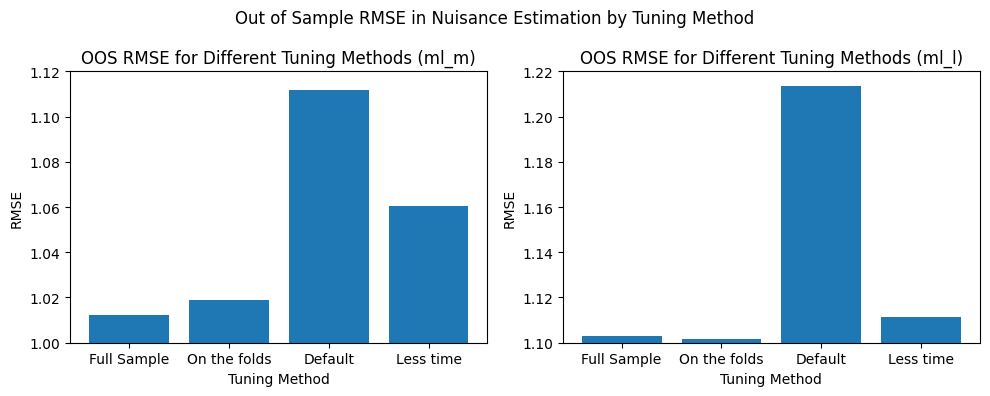

In [32]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
axs = axs.flatten()

axs[0].bar(x = ['Full Sample', 'On the folds', 'Default', 'Less time'],
           height=[rmse_dml_ml_m_fullsample, rmse_dml_ml_m_onfolds, rmse_dml_ml_m_untuned, rmse_dml_ml_m_lesstime])

axs[1].bar(x = ['Full Sample', 'On the folds', 'Default', 'Less time'],
           height=[rmse_dml_ml_l_fullsample, rmse_dml_ml_l_onfolds, rmse_dml_ml_l_untuned, rmse_dml_ml_l_lesstime])

axs[0].set_xlabel("Tuning Method")
axs[0].set_ylim((1,1.12))
axs[0].set_ylabel("RMSE")
axs[0].set_title("OOS RMSE for Different Tuning Methods (ml_m)")

axs[1].set_xlabel("Tuning Method")
axs[1].set_ylim((1.1,1.22))
axs[1].set_ylabel("RMSE")
axs[1].set_title("OOS RMSE for Different Tuning Methods (ml_l)")

fig.suptitle("Out of Sample RMSE in Nuisance Estimation by Tuning Method")
fig.tight_layout()

## Conclusion

This notebook highlights that tuning plays an important role and can be easily done using FLAML AutoML. In our [recent study](https://arxiv.org/abs/2402.04674) we provide more evidence for tuning with AutoML, especially that the full sample case in all investigated cases performed similarly to the full sample case and thus tuning time and complexity can be saved by tuning externally.

See also our fully automated API for tuning DoubleML objects using AutoML, called [AutoDoubleML](https://github.com/OliverSchacht/AutoDoubleML) which can be installed from Github for python.

## References

Bach, P., Schacht, O., Chernozhukov, V., Klaassen, S., & Spindler, M. (2024, March). Hyperparameter Tuning for Causal Inference with Double Machine Learning: A Simulation Study. In Causal Learning and Reasoning (pp. 1065-1117). PMLR.